#### Architecture - Semantic Search using Elastic Search


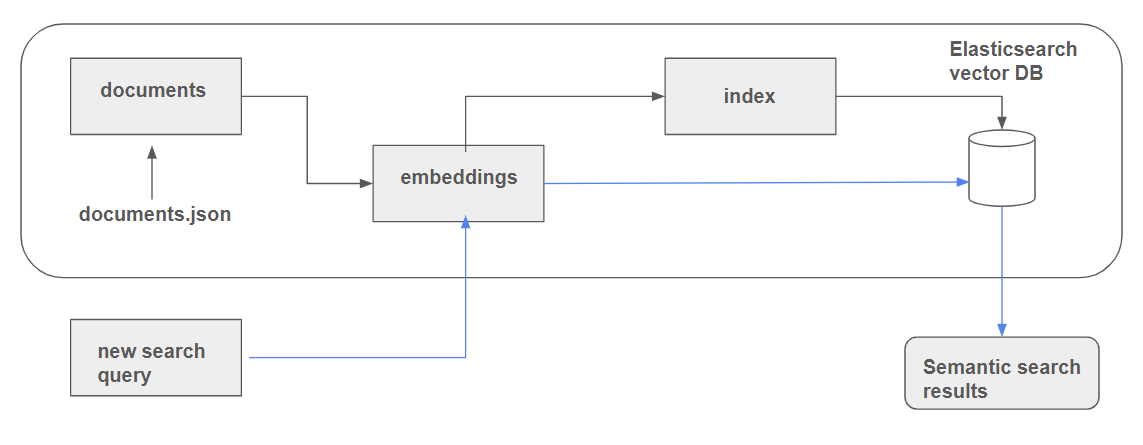

* Two very important concepts in Elasticsearch are documents and indexes.

* A document is collection of fields with their associated values. 

* To work with Elasticsearch you have to organize your data into documents, and then add all your documents to an index. 

* Index as a collection of documents that is stored in a highly optimized format designed to perform efficient searches.

#### Step 1: Prepare documents

In [1]:
import numpy

In [2]:
numpy.__version__

'1.26.4'

In [3]:
#!pip install numpy==1.26.4

In [4]:
import torch

In [5]:
import torch
#print(numpy.__version__)

In [6]:
import json

with open('documents.json', 'rt') as f_in:
    docs_raw = json.load(f_in)

In [55]:
docs_raw[2]['course']

'mlops-zoomcamp'

In [7]:
documents = []

for course_dict in docs_raw:
    for doc in course_dict['documents']:
        doc['course'] = course_dict['course']
        documents.append(doc)

documents[1]

{'text': 'GitHub - DataTalksClub data-engineering-zoomcamp#prerequisites',
 'section': 'General course-related questions',
 'question': 'Course - What are the prerequisites for this course?',
 'course': 'data-engineering-zoomcamp'}

#### Step 2: Create Embeddings using Pretrained Models

Sentence Transformers documentation here: https://www.sbert.net/docs/sentence_transformer/pretrained_models.html

In [8]:
#pip install sentence_transformers==2.7.0

In [9]:
# This is a new library compared to the previous modules. 
# Please perform "pip install sentence_transformers==2.7.0"
from sentence_transformers import SentenceTransformer

# if you get an error do the following:
# 1. Uninstall numpy 
# 2. Uninstall torch
# 3. pip install numpy==1.26.4
# 4. pip install torch
# run the above cell, it should work
model = SentenceTransformer("all-mpnet-base-v2")

C:\Users\user\miniconda3\envs\llm\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [59]:
print(len(model.encode("This is a simple sentence")))
model.encode("This is a simple sentence")

768


array([ 4.44872770e-03, -7.61314631e-02, -3.77453602e-04,  7.52524380e-03,
       -3.80979627e-02,  3.80131193e-02, -9.73005779e-03, -5.05396398e-03,
       -9.37977899e-03,  1.23888236e-02,  4.91276681e-02,  1.52209969e-02,
        3.80008481e-02, -6.41802773e-02,  9.42129176e-03, -5.19748889e-02,
        9.08066854e-02,  1.71115436e-02,  1.62125509e-02,  2.98866015e-02,
        1.50537817e-03,  8.35078210e-03,  3.78842130e-02, -1.01192892e-02,
        6.46104896e-03,  3.97503209e-05, -1.45217460e-02, -1.88468937e-02,
       -3.74039337e-02, -1.51664275e-03, -1.02680037e-02, -3.68062854e-02,
        2.36677546e-02, -6.46023080e-02,  1.96967039e-06, -5.01106260e-03,
       -2.80828355e-03, -1.92073472e-02, -8.65120292e-02,  2.83464640e-02,
       -5.38667329e-02,  3.63706015e-02, -2.26467997e-02,  2.87367646e-02,
       -1.32342046e-02,  1.08689599e-01,  3.70518677e-02,  3.38802300e-02,
       -5.30679561e-02,  3.61782275e-02, -1.35723129e-03, -3.63482870e-02,
       -2.78346427e-02, -

In [11]:
documents[5]

{'text': "There are 3 Zoom Camps in a year, as of 2024. However, they are for separate courses:\nData-Engineering (Jan - Apr)\nMLOps (May - Aug)\nMachine Learning (Sep - Jan)\nThere's only one Data-Engineering Zoomcamp “live” cohort per year, for the certification. Same as for the other Zoomcamps.\nThey follow pretty much the same schedule for each cohort per zoomcamp. For Data-Engineering it is (generally) from Jan-Apr of the year. If you’re not interested in the Certificate, you can take any zoom camps at any time, at your own pace, out of sync with any “live” cohort.",
 'section': 'General course-related questions',
 'question': 'Course - how many Zoomcamps in a year?',
 'course': 'data-engineering-zoomcamp'}

In [12]:
#created the dense vector using the pre-trained model
operations = []
for doc in documents:
    # Transforming the title into an embedding using the model
    doc["text_vector"] = model.encode(doc["text"]).tolist()
    operations.append(doc)

#### Step 3: Setup ElasticSearch connection 

In [13]:
import elasticsearch
elasticsearch.__version__

(8, 15, 0)

In [14]:
from elasticsearch import Elasticsearch
es_client = Elasticsearch('http://localhost:9200') 

es_client.info()

ObjectApiResponse({'name': '502795009ea7', 'cluster_name': 'docker-cluster', 'cluster_uuid': '12g39dxtTbexWni6s3Zyew', 'version': {'number': '8.4.3', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '42f05b9372a9a4a470db3b52817899b99a76ee73', 'build_date': '2022-10-04T07:17:24.662462378Z', 'build_snapshot': False, 'lucene_version': '9.3.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

#### Step 4: Create Mappings and Index

* Mapping is the process of defining how a document, and the fields it contains, are stored and indexed.

* Each document is a collection of fields, which each have their own data type.

* We can compare mapping to a database schema in how it describes the fields and properties that documents hold, the datatype of each field (e.g., string, integer, or date), and how those fields should be indexed and stored 



In [15]:
index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"} ,
            "text_vector": {"type": "dense_vector", "dims": 768, "index": True, "similarity": "cosine"},
        }
    }
}

In [16]:
index_name = "course-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

#### Step 5: Add documents into index

In [37]:
#operations[5]

In [27]:
# original code from the lesson but argument document was rejected
for doc in operations:
    try:
        es_client.index(index=index_name, document=doc)
    except Exception as e:
        print(e)

In [28]:
#for doc in operations:
 #   try:
  #      es_client.index(index=index_name, body=doc)
   # except Exception as e:
    #    print(e)
        

#### Step 6: Create end user query

In [29]:
search_term = "windows or mac?"
vector_search_term = model.encode(search_term)

In [30]:
query = {
    "field": "text_vector",
    "query_vector": vector_search_term,
    "k": 5,
    "num_candidates": 10000, 
}

In [33]:
res = es_client.search(index=index_name, knn=query, source=["text", "section", "question", "course"])
res["hits"]["hits"]

[{'_index': 'course-questions',
  '_id': 'HKXG2JEBmB8jpJxXV6Xq',
  '_score': 0.71479195,
  '_source': {'question': 'Environment - Is the course [Windows/mac/Linux/...] friendly?',
   'course': 'data-engineering-zoomcamp',
   'section': 'General course-related questions',
   'text': 'Yes! Linux is ideal but technically it should not matter. Students last year used all 3 OSes successfully'}},
 {'_index': 'course-questions',
  '_id': '0KXH2JEBmB8jpJxXSqga',
  '_score': 0.71479195,
  '_source': {'question': 'Environment - Is the course [Windows/mac/Linux/...] friendly?',
   'course': 'data-engineering-zoomcamp',
   'section': 'General course-related questions',
   'text': 'Yes! Linux is ideal but technically it should not matter. Students last year used all 3 OSes successfully'}},
 {'_index': 'course-questions',
  '_id': 'hKXZ2JEBmB8jpJxX9qy2',
  '_score': 0.71479195,
  '_source': {'question': 'Environment - Is the course [Windows/mac/Linux/...] friendly?',
   'course': 'data-engineering-z

#### Step 7: Perform Keyword search with Semantic Search (Hybrid/Advanced Search)

In [47]:
# Note: I made a minor modification to the query shown in the notebook here
# (compare to the one shown in the video)
# Included "knn" in the search query (to perform a semantic search) along with the filter  
knn_query = {
    "field": "text_vector",
    "query_vector": vector_search_term,
    "k": 5,
    "num_candidates": 10000
}

In [57]:
response = es_client.search(
    index=index_name,
    query={
        "match": {"course": "data-engineering-zoomcamp"},
    },
    knn=knn_query,
    size=5,
    explain=True
)

response=es_client.search(
    index=index_name,
    query={
        "bool": {
                "must": {
                    "multi_match":
                        {"query":"windows or python?",
                        "fields": ["question^3", "text", "section","title"],
                        "type": "best_fields"
                    }
                },
                "filter": {
                    "term": {
                        "course": "data-engineering-zoomcamp"
                    }
                }
            }
        }
    

)


In [58]:
response["hits"]["hits"]

[{'_shard': '[course-questions][0]',
  '_node': '2_Lsn6OqR1OuW1k5LrjH0w',
  '_index': 'course-questions',
  '_id': 'HKXG2JEBmB8jpJxXV6Xq',
  '_score': 1.4937689,
  '_source': {'text': 'Yes! Linux is ideal but technically it should not matter. Students last year used all 3 OSes successfully',
   'section': 'General course-related questions',
   'question': 'Environment - Is the course [Windows/mac/Linux/...] friendly?',
   'course': 'data-engineering-zoomcamp',
   'text_vector': [-0.026965467259287834,
    -0.0006261487724259496,
    -0.016629496589303017,
    0.05285152047872543,
    0.054765284061431885,
    -0.031339891254901886,
    0.029942581430077553,
    -0.04808562994003296,
    0.04467552527785301,
    0.0058394744992256165,
    0.016233038157224655,
    0.012001179158687592,
    -0.03122226521372795,
    0.016600513830780983,
    -0.04886903986334801,
    -0.06496306508779526,
    0.046434223651885986,
    -0.009297751821577549,
    -0.0642528384923935,
    -0.013732702471315

#### References

1. https://logz.io/blog/elasticsearch-mapping/#:~:text=Within%20a%20search%20engine%2C%20mapping,indexes%20and%20stores%20its%20fields

2. https://www.sbert.net/docs/sentence_transformer/pretrained_models.html

3. https://www.elastic.co/search-labs/tutorials

4. https://www.elastic.co/search-labs/blog/text-similarity-search-with-vectors-in-elasticsearch